In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # statistical data visualization
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# read the data
data_df = pd.read_csv('./storage/datasets/credit/cs-training.csv')
data_df = data_df.dropna(axis=0, how='any')  # drop rows with missing values

# remove Unamed
if 'Unnamed: 0' in data_df.columns:
    data_df = data_df.drop(columns=['Unnamed: 0'])


In [ ]:
print(f"Shape: {data_df.shape}")
print(f"Colunas: {data_df.columns.tolist()}")
print(f"Tipos: {data_df.dtypes}")
print(f"Missing values: {data_df.isnull().sum()}")

In [ ]:
def limpar_dados_final_para_modelo(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Limpeza FINAL e ROBUSTA antes do treino - garante 0 problemas
    """
    
    print("🔧 LIMPEZA FINAL ROBUSTA ANTES DO TREINO")
    print("=" * 50)
    
    # Fazer cópias
    X_train_clean = X_train.copy()
    X_val_clean = X_val.copy() 
    X_test_clean = X_test.copy()
    y_train_clean = y_train.copy()
    y_val_clean = y_val.copy()
    y_test_clean = y_test.copy()
    
    print(f"📊 DIAGNÓSTICO INICIAL:")
    print(f"   X_train shape: {X_train_clean.shape}")
    print(f"   X_train missing: {X_train_clean.isnull().sum().sum()}")
    print(f"   X_train infinitos: {np.isinf(X_train_clean.select_dtypes(include=[np.number])).sum().sum()}")
    print(f"   y_train missing: {y_train_clean.isnull().sum()}")
    
    # 1. LIMPAR TARGET PRIMEIRO
    print(f"\n1️⃣ LIMPEZA DO TARGET:")
    
    # Remover qualquer NaN do target
    valid_target_train = ~y_train_clean.isnull()
    valid_target_val = ~y_val_clean.isnull()
    valid_target_test = ~y_test_clean.isnull()
    
    if not valid_target_train.all():
        print(f"   ⚠️ Removendo {(~valid_target_train).sum()} NaNs do target treino")
        X_train_clean = X_train_clean[valid_target_train]
        y_train_clean = y_train_clean[valid_target_train]
    
    if not valid_target_val.all():
        print(f"   ⚠️ Removendo {(~valid_target_val).sum()} NaNs do target validação")
        X_val_clean = X_val_clean[valid_target_val]
        y_val_clean = y_val_clean[valid_target_val]
    
    if not valid_target_test.all():
        print(f"   ⚠️ Removendo {(~valid_target_test).sum()} NaNs do target teste")
        X_test_clean = X_test_clean[valid_target_test]
        y_test_clean = y_test_clean[valid_target_test]
    
    print(f"   ✅ Targets limpos")
    
    # 2. TRATAR COLUNAS NÃO NUMÉRICAS
    print(f"\n2️⃣ CONVERSÃO PARA NUMÉRICO:")
    
    # Identificar colunas não numéricas
    non_numeric_cols = X_train_clean.select_dtypes(exclude=[np.number]).columns.tolist()
    
    if non_numeric_cols:
        print(f"   Convertendo colunas não-numéricas: {non_numeric_cols}")
        
        from sklearn.preprocessing import LabelEncoder
        
        for col in non_numeric_cols:
            le = LabelEncoder()
            
            # Fit no treino
            X_train_clean[col] = le.fit_transform(X_train_clean[col].astype(str))
            
            # Transform nos outros (com tratamento de valores novos)
            try:
                X_val_clean[col] = le.transform(X_val_clean[col].astype(str))
            except ValueError:
                # Se há valores novos, usar -1
                X_val_clean[col] = pd.Series([le.transform([x])[0] if x in le.classes_ else -1 
                                            for x in X_val_clean[col].astype(str)])
            
            try:
                X_test_clean[col] = le.transform(X_test_clean[col].astype(str))
            except ValueError:
                X_test_clean[col] = pd.Series([le.transform([x])[0] if x in le.classes_ else -1 
                                             for x in X_test_clean[col].astype(str)])
        
        print(f"   ✅ {len(non_numeric_cols)} colunas convertidas")
    else:
        print(f"   ✅ Todas colunas já são numéricas")
    
    # 3. TRATAR INFINITOS
    print(f"\n3️⃣ TRATAMENTO DE INFINITOS:")
    
    for df_name, df in [("treino", X_train_clean), ("val", X_val_clean), ("teste", X_test_clean)]:
        inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
        
        if inf_count > 0:
            print(f"   🔧 {df_name}: {inf_count} infinitos encontrados")
            
            # Substituir infinitos
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if np.isinf(df[col]).any():
                    # Calcular percentis válidos
                    valid_values = df[col][np.isfinite(df[col])]
                    if len(valid_values) > 0:
                        p1 = valid_values.quantile(0.01) 
                        p99 = valid_values.quantile(0.99)
                        
                        df.loc[np.isposinf(df[col]), col] = p99
                        df.loc[np.isneginf(df[col]), col] = p1
                    else:
                        df[col].replace([np.inf, -np.inf], 0, inplace=True)
        else:
            print(f"   ✅ {df_name}: sem infinitos")
    
    # 4. TRATAR MISSING VALUES
    print(f"\n4️⃣ TRATAMENTO DE MISSING VALUES:")
    
    # Calcular estratégias de imputação baseadas apenas no treino
    imputation_strategies = {}
    
    for col in X_train_clean.columns:
        if X_train_clean[col].isnull().any():
            if X_train_clean[col].dtype in ['int64', 'float64']:
                # Numérica: mediana
                fill_value = X_train_clean[col].median()
                imputation_strategies[col] = ('median', fill_value)
            else:
                # Categórica: moda 
                mode_values = X_train_clean[col].mode()
                fill_value = mode_values[0] if len(mode_values) > 0 else 0
                imputation_strategies[col] = ('mode', fill_value)
    
    # Aplicar imputação em todos os conjuntos
    missing_tratados = 0
    for col, (strategy, fill_value) in imputation_strategies.items():
        print(f"   🔧 {col}: {strategy} = {fill_value}")
        
        # Aplicar em todos os conjuntos
        missing_tratados += X_train_clean[col].isnull().sum()
        missing_tratados += X_val_clean[col].isnull().sum() 
        missing_tratados += X_test_clean[col].isnull().sum()
        
        X_train_clean[col].fillna(fill_value, inplace=True)
        X_val_clean[col].fillna(fill_value, inplace=True)
        X_test_clean[col].fillna(fill_value, inplace=True)
    
    # Força bruta: qualquer NaN restante vira 0
    remaining_nan = (X_train_clean.isnull().sum().sum() + 
                     X_val_clean.isnull().sum().sum() + 
                     X_test_clean.isnull().sum().sum())
    
    if remaining_nan > 0:
        print(f"   🔨 FORÇA BRUTA: {remaining_nan} NaNs restantes → 0")
        X_train_clean.fillna(0, inplace=True)
        X_val_clean.fillna(0, inplace=True)
        X_test_clean.fillna(0, inplace=True)
    
    print(f"   ✅ {missing_tratados} missing values tratados")
    
    # 5. GARANTIR TIPOS CORRETOS
    print(f"\n5️⃣ GARANTINDO TIPOS CORRETOS:")
    
    # Forçar tudo para float64
    X_train_clean = X_train_clean.astype(np.float64)
    X_val_clean = X_val_clean.astype(np.float64)
    X_test_clean = X_test_clean.astype(np.float64)
    
    # Target para int
    y_train_clean = y_train_clean.astype(int)
    y_val_clean = y_val_clean.astype(int)
    y_test_clean = y_test_clean.astype(int)
    
    print(f"   ✅ Tipos padronizados")
    
    # 6. VERIFICAÇÃO FINAL RIGOROSA
    print(f"\n6️⃣ VERIFICAÇÃO FINAL RIGOROSA:")
    
    checks = {
        'X_train NaN': X_train_clean.isnull().sum().sum(),
        'X_val NaN': X_val_clean.isnull().sum().sum(),
        'X_test NaN': X_test_clean.isnull().sum().sum(),
        'X_train inf': np.isinf(X_train_clean).sum().sum(),
        'X_val inf': np.isinf(X_val_clean).sum().sum(), 
        'X_test inf': np.isinf(X_test_clean).sum().sum(),
        'y_train NaN': y_train_clean.isnull().sum(),
        'y_val NaN': y_val_clean.isnull().sum(),
        'y_test NaN': y_test_clean.isnull().sum()
    }
    
    all_perfect = True
    for check, value in checks.items():
        status = "✅" if value == 0 else "❌"
        if value != 0:
            all_perfect = False
        print(f"   {status} {check}: {value}")
    
    if all_perfect:
        print(f"\n🎉 DADOS PERFEITAMENTE LIMPOS!")
    else:
        print(f"\n❌ AINDA HÁ PROBLEMAS - VERIFICAR ACIMA")
        return None, None, None, None, None, None
    
    print(f"\n📊 SHAPES FINAIS:")
    print(f"   X_train: {X_train_clean.shape}")
    print(f"   X_val: {X_val_clean.shape}")
    print(f"   X_test: {X_test_clean.shape}")
    
    return X_train_clean, X_val_clean, X_test_clean, y_train_clean, y_val_clean, y_test_clean


In [ ]:
def tratar_monthly_income_com_mediana_e_log(df, col='MonthlyIncome'):
    """
    Trata MonthlyIncome: preenche missing com mediana, depois aplica log
    """
    
    df_tratado = df.copy()
    
    print(f"🔍 TRATAMENTO ESPECÍFICO: {col}")
    print("=" * 50)
    
    # 1. ANÁLISE INICIAL
    print(f"📊 Dados originais:")
    print(f"   Shape: {df[col].shape}")
    print(f"   Missing: {df[col].isnull().sum()} ({df[col].isnull().mean()*100:.1f}%)")
    print(f"   Min: {df[col].min()}")
    print(f"   Max: {df[col].max()}")
    print(f"   Média: {df[col].mean():.2f}")
    print(f"   Mediana: {df[col].median():.2f}")
    print(f"   Zeros: {(df[col] == 0).sum()}")
    print(f"   Negativos: {(df[col] < 0).sum()}")
    print(f"   Assimetria original: {df[col].skew():.2f}")
    
    # 2. PREENCHER MISSING COM MEDIANA
    mediana_original = df[col].median()
    print(f"\n💉 Preenchendo missing values:")
    print(f"   Mediana para preenchimento: {mediana_original:.2f}")
    
    df_tratado[col] = df[col].fillna(mediana_original)
    
    print(f"   ✅ Missing após preenchimento: {df_tratado[col].isnull().sum()}")
    
    # 3. VERIFICAR SE PODE APLICAR LOG
    min_value = df_tratado[col].min()
    print(f"\n🔬 Verificação para LOG:")
    print(f"   Valor mínimo: {min_value}")
    
    if min_value >= 0:
        print("   ✅ Todos valores >= 0, pode aplicar log")
        
        # 4. APLICAR TRANSFORMAÇÃO LOG
        col_log = f"{col}_log"
        df_tratado[col_log] = np.log1p(df_tratado[col])
        
        # 5. COMPARAR ASSIMETRIAS
        skew_original = df_tratado[col].skew()
        skew_log = df_tratado[col_log].skew()
        
        print(f"\n📈 Resultado da transformação:")
        print(f"   Assimetria original: {skew_original:.2f}")
        print(f"   Assimetria após log: {skew_log:.2f}")
        print(f"   Melhoria: {abs(skew_original) - abs(skew_log):.2f}")
        
        # 6. DECISÃO: MANTER OU DESCARTAR LOG
        if abs(skew_log) < abs(skew_original):
            # Log melhorou, substituir
            df_tratado[col] = df_tratado[col_log]
            df_tratado.drop(col_log, axis=1, inplace=True)
            print(f"   ✅ LOG MANTIDO (melhorou assimetria)")
            transformacao_final = f"Mediana + Log1p"
        else:
            # Log piorou, manter original
            df_tratado.drop(col_log, axis=1, inplace=True)
            print(f"   ❌ LOG DESCARTADO (piorou assimetria)")
            transformacao_final = f"Apenas mediana"
        
        # 7. VISUALIZAÇÃO COMPARATIVA
        print(f"\n📊 Criando visualização comparativa...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Tratamento de {col}', fontsize=16, fontweight='bold')
        
        # Original (com missing)
        original_clean = df[col].dropna()
        axes[0, 0].hist(original_clean, bins=50, alpha=0.7, color='red', edgecolor='black')
        axes[0, 0].set_title(f'Original (Skew: {original_clean.skew():.2f})')
        axes[0, 0].set_xlabel('Valor Original')
        axes[0, 0].set_ylabel('Frequência')
        
        # Após preencher com mediana
        axes[0, 1].hist(df_tratado[col], bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[0, 1].set_title(f'Após Mediana (Skew: {df_tratado[col].skew():.2f})')
        axes[0, 1].set_xlabel('Após Preenchimento')
        axes[0, 1].set_ylabel('Frequência')
        
        # Log transformation (se aplicada)
        if transformacao_final == "Mediana + Log1p":
            axes[1, 0].hist(df_tratado[col], bins=50, alpha=0.7, color='green', edgecolor='black')
            axes[1, 0].set_title(f'Final: Log Applied (Skew: {df_tratado[col].skew():.2f})')
            axes[1, 0].set_xlabel('Log Transformed')
        else:
            # Mostrar como seria o log (para comparação)
            temp_log = np.log1p(df_tratado[col])
            axes[1, 0].hist(temp_log, bins=50, alpha=0.7, color='orange', edgecolor='black')
            axes[1, 0].set_title(f'Log (não usado) (Skew: {temp_log.skew():.2f})')
            axes[1, 0].set_xlabel('Log (descartado)')
        
        # Boxplot final
        axes[1, 1].boxplot(df_tratado[col])
        axes[1, 1].set_title(f'Boxplot Final')
        axes[1, 1].set_ylabel('Valores Finais')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"   ❌ Valores negativos detectados ({min_value})")
        print(f"   💡 Aplicando winsorização em vez de log")
        
        from scipy.stats import mstats
        df_tratado[col] = mstats.winsorize(df_tratado[col], limits=[0.05, 0.05])
        transformacao_final = "Mediana + Winsorização"
    
    # 8. RESUMO FINAL
    print(f"\n✅ RESUMO FINAL:")
    print(f"   Transformação aplicada: {transformacao_final}")
    print(f"   Assimetria final: {df_tratado[col].skew():.2f}")
    print(f"   Missing values finais: {df_tratado[col].isnull().sum()}")
    print(f"   Shape final: {df_tratado[col].shape}")
    
    # Classificar resultado final
    final_skew = abs(df_tratado[col].skew())
    if final_skew <= 0.5:
        status = "✅ EXCELENTE (aproximadamente simétrica)"
    elif final_skew <= 1.0:
        status = "🟢 BOA (moderadamente assimétrica)"
    elif final_skew <= 2.0:
        status = "🟡 ACEITÁVEL (assimétrica)"
    else:
        status = "🚨 AINDA PROBLEMÁTICA (extremamente assimétrica)"
    
    print(f"   Status final: {status}")
    
    return df_tratado

# APLICAR NO SEU DATASET
print("🚀 Aplicando tratamento em MonthlyIncome...")
df_completely_clean = tratar_monthly_income_com_mediana_e_log(data_df, 'MonthlyIncome')

# Verificar resultado
print(f"\n🎯 VERIFICAÇÃO FINAL:")
print(f"MonthlyIncome - Assimetria: {df_completely_clean['MonthlyIncome'].skew():.2f}")

In [ ]:
def analise_univariada_corrigida(df, target_col='SeriousDlqin2yrs'):
    """
    Análise univariada com transformação logarítmica corrigida
    """
    
    # Criar cópia do dataframe para não alterar o original
    df_clean = df.copy()
    
    # Remover colunas desnecessárias
    cols_to_remove = []
    for col in df_clean.columns:
        if 'unnamed' in col.lower() or 'index' in col.lower() or col.lower() == 'id':
            cols_to_remove.append(col)
    
    if cols_to_remove:
        print(f"Removendo colunas desnecessárias: {cols_to_remove}")
        df_clean = df_clean.drop(columns=cols_to_remove)

    # aplicar tratar_monthly_income_com_mediana_e_log
    if 'MonthlyIncome' in df_clean.columns:
        df_clean = tratar_monthly_income_com_mediana_e_log(df_clean, 'MonthlyIncome')
    else:
        print("Coluna 'MonthlyIncome' não encontrada, pulando tratamento específico.")
    # Separar variáveis numéricas e categóricas
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\n=== ANÁLISE UNIVARIADA ===")
    print(f"Variáveis numéricas: {len(numeric_cols)}")
    print(f"Variáveis categóricas: {len(categorical_cols)}")
    print(f"Target: {target_col}")
    print("-" * 60)
    
    # Análise de variáveis numéricas
    for col in numeric_cols:
        print(f"\nVariável: {col}")
        print("-" * 40)
        
        # Verificar se dados são válidos
        if df_clean[col].isnull().all():
            print("❌ Todos os valores são NaN - pulando análise")
            continue
        
        # Estatísticas descritivas
        stats = df_clean[col].describe()
        skewness = df_clean[col].skew()
        kurtosis = df_clean[col].kurtosis()
        
        print(f"Média: {stats['mean']:.2f}")
        print(f"Mediana: {stats['50%']:.2f}")
        print(f"Desvio Padrão: {stats['std']:.2f}")
        print(f"Assimetria: {skewness:.2f}")
        print(f"Curtose: {kurtosis:.2f}")
        print(f"Missing Values: {df_clean[col].isnull().sum()} ({df_clean[col].isnull().mean()*100:.1f}%)")
        
        # Interpretação da assimetria
        if abs(skewness) <= 0.5:
            interpretacao = "✅ Aproximadamente simétrica"
        elif abs(skewness) <= 1.0:
            interpretacao = "🟡 Moderadamente assimétrica"
        elif abs(skewness) <= 2.0:
            interpretacao = "🟠 Assimétrica"
        else:
            interpretacao = "🚨 Extremamente assimétrica"
        
        print(f"Interpretação: {interpretacao}")
        
        # Visualização
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Histograma
        valid_data = df_clean[col].dropna()
        if len(valid_data) > 0:
            axes[0].hist(valid_data, bins=30, alpha=0.7, edgecolor='black')
            axes[0].set_title(f'Distribuição de {col}\n(Skew: {skewness:.2f})')
            axes[0].set_xlabel(col)
            axes[0].set_ylabel('Frequência')
            
            # Boxplot
            axes[1].boxplot(valid_data)
            axes[1].set_title(f'Boxplot de {col}')
            axes[1].set_ylabel(col)
        
        plt.tight_layout()
        plt.show()
    
    return df_clean

# Usar a versão corrigida
df_analisado = analise_univariada_corrigida(data_df)

In [ ]:
def investigacao_completa_monthly_income(df):
    """
    Investigação forense da MonthlyIncome para descobrir o problema
    """
    
    print("🕵️ INVESTIGAÇÃO FORENSE: MonthlyIncome")
    print("=" * 60)
    
    # 1. ANÁLISE DOS DADOS BRUTOS
    print("1️⃣ ANÁLISE DOS DADOS BRUTOS:")
    print("-" * 40)
    
    income_col = 'MonthlyIncome'
    target_col = 'SeriousDlqin2yrs'
    
    if income_col not in df.columns:
        print(f"❌ Coluna {income_col} não encontrada!")
        print(f"Colunas disponíveis: {list(df.columns)}")
        return
    
    print(f"📊 Estatísticas básicas:")
    print(f"   Tamanho: {len(df[income_col])}")
    print(f"   Tipo: {df[income_col].dtype}")
    print(f"   Missing: {df[income_col].isnull().sum()} ({df[income_col].isnull().mean()*100:.1f}%)")
    print(f"   Únicos: {df[income_col].nunique()}")
    print(f"   Min: {df[income_col].min()}")
    print(f"   Max: {df[income_col].max()}")
    print(f"   Média: {df[income_col].mean():.2f}")
    print(f"   Mediana: {df[income_col].median():.2f}")
    print(f"   Std: {df[income_col].std():.2f}")
    
    # 2. VERIFICAR SE FOI TRANSFORMADA
    print(f"\n2️⃣ VERIFICAR TRANSFORMAÇÕES:")
    print("-" * 40)
    
    # Checar se parece com dados transformados (log)
    if df[income_col].min() < 0:
        print(f"⚠️  PROBLEMA: Valores negativos detectados!")
        print(f"   Valores negativos: {(df[income_col] < 0).sum()}")
        print(f"   Menor valor: {df[income_col].min()}")
    
    if df[income_col].max() < 20:  # Se max < 20, provavelmente foi aplicado log
        print(f"🚨 SUSPEITA: Dados parecem estar em escala logarítmica!")
        print(f"   Max value: {df[income_col].max()}")
        print(f"   Isso explicaria a correlação baixa!")
    
    # 3. ANÁLISE DE DISTRIBUIÇÃO
    print(f"\n3️⃣ ANÁLISE DE DISTRIBUIÇÃO:")
    print("-" * 40)
    
    # Valores mais comuns
    print(f"Top 10 valores mais frequentes:")
    value_counts = df[income_col].value_counts().head(10)
    for valor, freq in value_counts.items():
        print(f"   {valor:.2f}: {freq} vezes ({freq/len(df)*100:.1f}%)")
    
    # 4. CORRELAÇÃO POR FAIXAS
    print(f"\n4️⃣ ANÁLISE DE CORRELAÇÃO POR FAIXAS:")
    print("-" * 40)
    
    # Criar quartis para análise
    try:
        quartis = pd.qcut(df[income_col], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        analise_quartis = df.groupby(quartis)[target_col].agg(['count', 'mean']).round(3)
        print(f"Taxa de inadimplência por quartil de renda:")
        print(analise_quartis)
        
        # Se Q1 tem taxa maior que Q4, está correto
        if analise_quartis.loc['Q1', 'mean'] > analise_quartis.loc['Q4', 'mean']:
            print(f"✅ Padrão esperado: Q1 > Q4 (menor renda = maior risco)")
        else:
            print(f"🚨 PROBLEMA: Padrão invertido!")
            
    except Exception as e:
        print(f"❌ Erro na análise por quartis: {e}")
    
    # 5. TESTE DE DIFERENTES CORRELAÇÕES
    print(f"\n5️⃣ TESTE DE DIFERENTES CORRELAÇÕES:")
    print("-" * 40)
    
    from scipy.stats import pearsonr, spearmanr
    
    # Remover missing para correlação
    valid_mask = df[income_col].notna() & df[target_col].notna()
    income_clean = df[income_col][valid_mask]
    target_clean = df[target_col][valid_mask]
    
    pearson_corr, pearson_p = pearsonr(income_clean, target_clean)
    spearman_corr, spearman_p = spearmanr(income_clean, target_clean)
    
    print(f"Pearson:  {pearson_corr:.6f} (p-value: {pearson_p:.6f})")
    print(f"Spearman: {spearman_corr:.6f} (p-value: {spearman_p:.6f})")
    
    # 6. VISUALIZAÇÃO DIAGNÓSTICA
    print(f"\n6️⃣ CRIANDO VISUALIZAÇÕES DIAGNÓSTICAS...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Investigação MonthlyIncome', fontsize=16, fontweight='bold')
    
    # Histograma
    axes[0, 0].hist(income_clean, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title(f'Distribuição MonthlyIncome')
    axes[0, 0].set_xlabel('MonthlyIncome')
    axes[0, 0].set_ylabel('Frequência')
    
    # Boxplot
    axes[0, 1].boxplot(income_clean)
    axes[0, 1].set_title('Boxplot MonthlyIncome')
    axes[0, 1].set_ylabel('MonthlyIncome')
    
    # Scatter plot vs target
    axes[0, 2].scatter(income_clean, target_clean, alpha=0.1)
    axes[0, 2].set_title(f'MonthlyIncome vs Target\nr={pearson_corr:.4f}')
    axes[0, 2].set_xlabel('MonthlyIncome')
    axes[0, 2].set_ylabel('SeriousDlqin2yrs')
    
    # Taxa de default por faixa de renda
    try:
        bins = pd.cut(income_clean, bins=20)
        default_by_bin = df[valid_mask].groupby(bins)[target_col].mean()
        
        axes[1, 0].plot(range(len(default_by_bin)), default_by_bin.values, marker='o')
        axes[1, 0].set_title('Taxa Default por Faixa de Renda')
        axes[1, 0].set_xlabel('Faixa de Renda (ordenada)')
        axes[1, 0].set_ylabel('Taxa de Default')
        axes[1, 0].tick_params(axis='x', rotation=45)
    except:
        axes[1, 0].text(0.5, 0.5, 'Erro na análise por faixas', ha='center', va='center')
    
    # QQ plot para verificar normalidade
    from scipy import stats
    stats.probplot(income_clean, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (Normalidade)')
    
    # Correlação rolling (para verificar estabilidade)
    try:
        # Ordenar por renda e calcular correlação rolling
        df_sorted = df[valid_mask].sort_values(income_col)
        window_size = len(df_sorted) // 10
        
        correlacoes_rolling = []
        for i in range(window_size, len(df_sorted), window_size//2):
            subset_income = df_sorted[income_col].iloc[i-window_size:i]
            subset_target = df_sorted[target_col].iloc[i-window_size:i]
            corr_temp = subset_income.corr(subset_target)
            correlacoes_rolling.append(corr_temp)
        
        axes[1, 2].plot(correlacoes_rolling, marker='o')
        axes[1, 2].set_title('Correlação Rolling')
        axes[1, 2].set_ylabel('Correlação')
        axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    except:
        axes[1, 2].text(0.5, 0.5, 'Erro na correlação rolling', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 7. DIAGNÓSTICO E RECOMENDAÇÕES
    print(f"\n7️⃣ DIAGNÓSTICO E RECOMENDAÇÕES:")
    print("-" * 40)
    
    problemas = []
    solucoes = []
    
    if abs(pearson_corr) < 0.1:
        problemas.append("Correlação suspeitamente baixa")
        solucoes.append("Verificar se dados foram transformados incorretamente")
    
    if df[income_col].max() < 20:
        problemas.append("Dados parecem estar em escala logarítmica")
        solucoes.append("Aplicar exponencial para reverter transformação log")
    
    if df[income_col].min() < 0:
        problemas.append("Valores negativos em renda")
        solucoes.append("Investigar origem dos valores negativos")
    
    if df[income_col].isnull().sum() > len(df) * 0.1:
        problemas.append("Muitos missing values")
        solucoes.append("Melhorar estratégia de imputação")
    
    print("🚨 PROBLEMAS IDENTIFICADOS:")
    for i, problema in enumerate(problemas, 1):
        print(f"   {i}. {problema}")
    
    print("\n💡 SOLUÇÕES RECOMENDADAS:")
    for i, solucao in enumerate(solucoes, 1):
        print(f"   {i}. {solucao}")
    
    return {
        'correlacao_pearson': pearson_corr,
        'correlacao_spearman': spearman_corr,
        'problemas': problemas,
        'solucoes': solucoes,
        'dados_limpos': {'income': income_clean, 'target': target_clean}
    }

# EXECUTAR INVESTIGAÇÃO
resultado_investigacao = investigacao_completa_monthly_income(data_df)
# Exibir resultados da investigação
resultado_investigacao

In [ ]:
def corrigir_monthly_income_valores_negativos(df):
    """
    Corrige especificamente valores negativos na MonthlyIncome
    """
    
    print("🔧 CORREÇÃO: Valores negativos em MonthlyIncome")
    print("=" * 50)
    
    df_corrigido = df.copy()
    income_col = 'MonthlyIncome'
    target_col = 'SeriousDlqin2yrs'
    
    # 1. DIAGNÓSTICO DOS VALORES NEGATIVOS
    print("1️⃣ DIAGNÓSTICO:")
    print("-" * 30)
    
    valores_negativos = df[income_col] < 0
    valores_zero = df[income_col] == 0
    valores_positivos = df[income_col] > 0
    valores_missing = df[income_col].isnull()
    
    print(f"📊 Distribuição dos valores:")
    print(f"   Negativos: {valores_negativos.sum()} ({valores_negativos.mean()*100:.1f}%)")
    print(f"   Zeros: {valores_zero.sum()} ({valores_zero.mean()*100:.1f}%)")
    print(f"   Positivos: {valores_positivos.sum()} ({valores_positivos.mean()*100:.1f}%)")
    print(f"   Missing: {valores_missing.sum()} ({valores_missing.mean()*100:.1f}%)")
    
    if valores_negativos.sum() > 0:
        print(f"\n🚨 Valores negativos encontrados:")
        print(f"   Menor valor: {df[income_col].min()}")
        print(f"   Valores únicos negativos: {df[income_col][valores_negativos].unique()[:10]}")
    
    # 2. ESTRATÉGIAS DE CORREÇÃO
    print(f"\n2️⃣ APLICANDO CORREÇÕES:")
    print("-" * 30)
    
    # Estratégia 1: Substituir negativos por NaN
    if valores_negativos.sum() > 0:
        print(f"🔄 Convertendo {valores_negativos.sum()} valores negativos para NaN...")
        df_corrigido.loc[valores_negativos, income_col] = np.nan
    
    # Estratégia 2: Imputação inteligente baseada em outras variáveis
    print(f"🔄 Imputando valores missing...")
    
    # Calcular mediana por faixa etária (mais preciso que mediana geral)
    if 'age' in df_corrigido.columns:
        print("   Usando mediana por faixa etária...")
        
        # Criar faixas etárias temporárias
        df_corrigido['faixa_etaria_temp'] = pd.cut(
            df_corrigido['age'], 
            bins=[0, 25, 35, 45, 55, 100], 
            labels=['18-25', '26-35', '36-45', '46-55', '55+']
        )
        
        # Calcular mediana por faixa (apenas valores válidos)
        medianas_por_idade = {}
        for faixa in df_corrigido['faixa_etaria_temp'].unique():
            if pd.notna(faixa):
                mask_faixa = df_corrigido['faixa_etaria_temp'] == faixa
                mask_valid = df_corrigido[income_col] > 0  # Apenas positivos
                
                if (mask_faixa & mask_valid).sum() > 0:
                    mediana_faixa = df_corrigido.loc[mask_faixa & mask_valid, income_col].median()
                    medianas_por_idade[faixa] = mediana_faixa
                    print(f"   {faixa}: mediana = ${mediana_faixa:,.2f}")
        
        # Aplicar imputação por faixa
        for faixa, mediana in medianas_por_idade.items():
            mask_faixa = df_corrigido['faixa_etaria_temp'] == faixa
            mask_missing = df_corrigido[income_col].isnull()
            
            count_imputados = (mask_faixa & mask_missing).sum()
            if count_imputados > 0:
                df_corrigido.loc[mask_faixa & mask_missing, income_col] = mediana
                print(f"   ✅ {count_imputados} valores imputados para faixa {faixa}")
        
        df_corrigido.drop('faixa_etaria_temp', axis=1, inplace=True)
    
    # Imputar restantes com mediana geral
    missing_restantes = df_corrigido[income_col].isnull().sum()
    if missing_restantes > 0:
        mediana_geral = df_corrigido[income_col][df_corrigido[income_col] > 0].median()
        df_corrigido[income_col].fillna(mediana_geral, inplace=True)
        print(f"   ✅ {missing_restantes} valores restantes imputados com mediana geral: ${mediana_geral:,.2f}")
    
    # 3. VERIFICAÇÃO FINAL
    print(f"\n3️⃣ VERIFICAÇÃO APÓS CORREÇÃO:")
    print("-" * 30)
    
    print(f"📊 Estatísticas finais:")
    print(f"   Min: ${df_corrigido[income_col].min():,.2f}")
    print(f"   Max: ${df_corrigido[income_col].max():,.2f}")
    print(f"   Média: ${df_corrigido[income_col].mean():,.2f}")
    print(f"   Mediana: ${df_corrigido[income_col].median():,.2f}")
    print(f"   Missing: {df_corrigido[income_col].isnull().sum()}")
    print(f"   Negativos: {(df_corrigido[income_col] < 0).sum()}")
    print(f"   Zeros: {(df_corrigido[income_col] == 0).sum()}")
    
    # 4. TESTAR CORRELAÇÃO
    print(f"\n4️⃣ TESTE DE CORRELAÇÃO:")
    print("-" * 30)
    
    # Correlação original vs corrigida
    corr_original = df[income_col][df[income_col] > 0].corr(
        df[target_col][df[income_col] > 0]
    ) if (df[income_col] > 0).sum() > 0 else 0
    
    corr_corrigida = df_corrigido[income_col].corr(df_corrigido[target_col])
    
    print(f"Correlação original (só valores positivos): {corr_original:.4f}")
    print(f"Correlação após correção: {corr_corrigida:.4f}")
    print(f"Melhoria: {abs(corr_corrigida) - abs(corr_original):.4f}")
    
    # 5. ANÁLISE POR QUARTIS (deve mostrar padrão claro)
    print(f"\n5️⃣ ANÁLISE POR QUARTIS DE RENDA:")
    print("-" * 30)
    
    try:
        # Criar quartis da renda corrigida
        quartis = pd.qcut(df_corrigido[income_col], q=4, labels=['Q1_Baixa', 'Q2_Média-', 'Q3_Média+', 'Q4_Alta'])
        
        analise_quartis = df_corrigido.groupby(quartis)[target_col].agg([
            ('total', 'count'),
            ('defaults', 'sum'), 
            ('taxa_default', 'mean')
        ]).round(4)
        
        print("Taxa de inadimplência por quartil de renda:")
        print(analise_quartis)
        
        # Verificar se padrão está correto (Q1 > Q4)
        taxa_q1 = analise_quartis.loc['Q1_Baixa', 'taxa_default']
        taxa_q4 = analise_quartis.loc['Q4_Alta', 'taxa_default']
        
        if taxa_q1 > taxa_q4:
            print(f"\n✅ PADRÃO CORRETO: Renda baixa ({taxa_q1:.3f}) > Renda alta ({taxa_q4:.3f})")
            print(f"   Diferença: {taxa_q1 - taxa_q4:.3f} pontos percentuais")
        else:
            print(f"\n⚠️  Padrão ainda não ideal, mas melhor que antes")
        
    except Exception as e:
        print(f"Erro na análise por quartis: {e}")
    
    # 6. VISUALIZAÇÃO
    print(f"\n6️⃣ CRIANDO VISUALIZAÇÃO COMPARATIVA...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Correção MonthlyIncome - Antes vs Depois', fontsize=16, fontweight='bold')
    
    # Histograma original (apenas valores válidos)
    dados_original_validos = df[income_col][df[income_col] > 0]
    axes[0, 0].hist(dados_original_validos, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0, 0].set_title(f'Original (só positivos)\nCorr: {corr_original:.4f}')
    axes[0, 0].set_xlabel('MonthlyIncome Original')
    axes[0, 0].set_ylabel('Frequência')
    
    # Histograma corrigido
    axes[0, 1].hist(df_corrigido[income_col], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title(f'Corrigido\nCorr: {corr_corrigida:.4f}')
    axes[0, 1].set_xlabel('MonthlyIncome Corrigido')
    axes[0, 1].set_ylabel('Frequência')
    
    # Boxplot comparativo
    box_data = [dados_original_validos, df_corrigido[income_col]]
    axes[1, 0].boxplot(box_data, labels=['Original', 'Corrigido'])
    axes[1, 0].set_title('Boxplot Comparativo')
    axes[1, 0].set_ylabel('MonthlyIncome')
    
    # Taxa de default por faixa de renda
    try:
        quartis_plot = pd.qcut(df_corrigido[income_col], q=10, labels=False)
        default_por_decil = df_corrigido.groupby(quartis_plot)[target_col].mean()
        
        axes[1, 1].plot(range(len(default_por_decil)), default_por_decil.values, 
                       marker='o', linewidth=2, markersize=6)
        axes[1, 1].set_title('Taxa Default por Decil de Renda')
        axes[1, 1].set_xlabel('Decil de Renda (1=menor, 10=maior)')
        axes[1, 1].set_ylabel('Taxa de Default')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Linha de tendência
        z = np.polyfit(range(len(default_por_decil)), default_por_decil.values, 1)
        p = np.poly1d(z)
        axes[1, 1].plot(range(len(default_por_decil)), p(range(len(default_por_decil))), 
                       "r--", alpha=0.8, label=f'Tendência (slope={z[0]:.4f})')
        axes[1, 1].legend()
        
    except:
        axes[1, 1].text(0.5, 0.5, 'Erro na análise por decis', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return df_corrigido, corr_corrigida

# APLICAR A CORREÇÃO
print("🚀 Corrigindo valores negativos em MonthlyIncome...")
df_income_corrigido, correlacao_final = corrigir_monthly_income_valores_negativos(data_df)

print(f"\n🎯 RESULTADO FINAL:")
print(f"Correlação MonthlyIncome vs SeriousDlqin2yrs: {correlacao_final:.4f}")

if abs(correlacao_final) > 0.1:
    print("✅ SUCESSO! Correlação agora é significativa!")
else:
    print("⚠️  Ainda baixa - pode haver outros problemas nos dados")

In [ ]:
def analise_bivariada_corrigida(df, target_col='SeriousDlqin2yrs'):
    """
    Análise bivariada com correção automática de problemas nos dados
    """
    
    print("🔍 ANÁLISE BIVARIADA COM CORREÇÃO AUTOMÁTICA")
    print("=" * 60)
    
    # 1. CRIAR CÓPIA E APLICAR CORREÇÕES NECESSÁRIAS
    df_corrigido = df.copy()
    
    # Verificar e corrigir MonthlyIncome se necessário
    if 'MonthlyIncome' in df_corrigido.columns:
        valores_negativos = (df_corrigido['MonthlyIncome'] < 0).sum()
        correlacao_original = df_corrigido['MonthlyIncome'].corr(df_corrigido[target_col])
        
        print(f"📊 Status MonthlyIncome:")
        print(f"   Valores negativos: {valores_negativos}")
        print(f"   Correlação atual: {correlacao_original:.4f}")
        
        # Aplicar correção se necessário
        if valores_negativos > 0 or abs(correlacao_original) < 0.05:
            print(f"🔧 Aplicando correção em MonthlyIncome...")
            df_corrigido, nova_correlacao = corrigir_monthly_income_valores_negativos(df_corrigido)
            print(f"   ✅ Nova correlação: {nova_correlacao:.4f}")
        else:
            print(f"   ✅ MonthlyIncome já está adequada")
    
    # 2. IDENTIFICAR COLUNAS NUMÉRICAS
    numeric_cols = df_corrigido.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    print(f"\n📈 ANÁLISE DE CORRELAÇÕES")
    print("-" * 40)
    
    # 3. MATRIZ DE CORRELAÇÃO
    corr_matrix = df_corrigido[numeric_cols + [target_col]].corr()
    
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mostrar apenas triângulo inferior
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                fmt='.3f', square=True, mask=mask, 
                cbar_kws={'label': 'Correlação de Pearson'})
    plt.title('Matriz de Correlação - Dataset Corrigido', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 4. RANKING DE CORRELAÇÕES COM TARGET
    target_corr = corr_matrix[target_col].sort_values(ascending=False)
    
    print(f"🎯 CORRELAÇÕES COM {target_col.upper()}:")
    print("-" * 60)
    
    for i, (var, corr) in enumerate(target_corr.items(), 1):
        if var != target_col:
            # Classificar força da correlação
            abs_corr = abs(corr)
            if abs_corr >= 0.3:
                forca = "🔴 FORTE"
                emoji_forca = "🚨"
            elif abs_corr >= 0.1:
                forca = "🟡 MODERADA"
                emoji_forca = "⚠️"
            elif abs_corr >= 0.05:
                forca = "🟢 FRACA"
                emoji_forca = "💡"
            else:
                forca = "⚪ MUITO FRACA"
                emoji_forca = "📝"
            
            # Direção da correlação
            if corr > 0:
                direcao = "↗️ AUMENTA risco"
                cor_direcao = "🔴"
            else:
                direcao = "↘️ DIMINUI risco"
                cor_direcao = "🔵"
            
            print(f"{i:2d}. {var:<35} {corr:7.4f} {forca} {cor_direcao} {direcao}")
    
    # 5. ANÁLISE POR GRUPOS DE VARIÁVEIS
    print(f"\n📊 ANÁLISE POR GRUPOS:")
    print("-" * 40)
    
    # Grupo: Comportamento de Pagamento
    comportamento_vars = [var for var in numeric_cols if any(word in var.lower() 
                         for word in ['days', 'time', 'late', 'past', 'due'])]
    
    if comportamento_vars:
        print(f"📈 COMPORTAMENTO DE PAGAMENTO:")
        comportamento_corrs = [(var, target_corr[var]) for var in comportamento_vars if var in target_corr]
        comportamento_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        for var, corr in comportamento_corrs:
            print(f"   {var:<40} {corr:6.3f}")
        
        # Média das correlações de comportamento
        media_comportamento = np.mean([abs(corr) for _, corr in comportamento_corrs])
        print(f"   💡 Correlação média (absoluta): {media_comportamento:.3f}")
    
    # Grupo: Características Financeiras
    financeiro_vars = [var for var in numeric_cols if any(word in var.lower() 
                      for word in ['income', 'debt', 'ratio', 'credit', 'revolving'])]
    
    if financeiro_vars:
        print(f"\n💰 CARACTERÍSTICAS FINANCEIRAS:")
        financeiro_corrs = [(var, target_corr[var]) for var in financeiro_vars if var in target_corr]
        financeiro_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        for var, corr in financeiro_corrs:
            print(f"   {var:<40} {corr:6.3f}")
        
        media_financeiro = np.mean([abs(corr) for _, corr in financeiro_corrs])
        print(f"   💡 Correlação média (absoluta): {media_financeiro:.3f}")
    
    # Grupo: Demografia
    demo_vars = [var for var in numeric_cols if any(word in var.lower() 
                for word in ['age', 'dependent'])]
    
    if demo_vars:
        print(f"\n👥 DEMOGRÁFICAS:")
        demo_corrs = [(var, target_corr[var]) for var in demo_vars if var in target_corr]
        demo_corrs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        for var, corr in demo_corrs:
            print(f"   {var:<40} {corr:6.3f}")
    
    # 6. INSIGHTS E RECOMENDAÇÕES
    print(f"\n💡 INSIGHTS E RECOMENDAÇÕES:")
    print("-" * 40)
    
    # Top 3 preditores
    top_3 = [(var, corr) for var, corr in target_corr.items() if var != target_col][:3]
    print(f"🏆 TOP 3 PREDITORES:")
    for i, (var, corr) in enumerate(top_3, 1):
        print(f"   {i}. {var} (r={corr:.3f})")
    
    # Verificar se MonthlyIncome melhorou
    if 'MonthlyIncome' in target_corr:
        income_corr = target_corr['MonthlyIncome']
        if abs(income_corr) >= 0.1:
            print(f"✅ MonthlyIncome agora tem correlação significativa: {income_corr:.3f}")
        else:
            print(f"⚠️  MonthlyIncome ainda com correlação baixa: {income_corr:.3f}")
    
    # Identificar variáveis problemáticas
    vars_problematicas = [var for var, corr in target_corr.items() 
                         if var != target_col and abs(corr) < 0.01]
    
    if vars_problematicas:
        print(f"\n⚠️  VARIÁVEIS COM CORRELAÇÃO MUITO BAIXA:")
        for var in vars_problematicas:
            print(f"   • {var} (r={target_corr[var]:.4f})")
        print(f"   💡 Considere remover ou transformar essas variáveis")
    
    # 7. ANÁLISE DE VARIÁVEIS CATEGÓRICAS (se existirem)
    categorical_cols = df_corrigido.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if categorical_cols:
        print(f"\n📋 ANÁLISE DE VARIÁVEIS CATEGÓRICAS:")
        print("-" * 40)
        
        for col in categorical_cols:
            print(f"\n📊 {col} vs {target_col}:")
            print("-" * 30)
            
            # Tabela de contingência
            try:
                contingency = pd.crosstab(df_corrigido[col], df_corrigido[target_col], normalize='index')
                print(contingency.round(3))
                
                # Teste qui-quadrado
                from scipy.stats import chi2_contingency
                chi2, p_value, _, _ = chi2_contingency(pd.crosstab(df_corrigido[col], df_corrigido[target_col]))
                print(f"Chi-squared test: χ² = {chi2:.3f}, p-value = {p_value:.6f}")
                
                if p_value < 0.05:
                    print("✅ Associação estatisticamente significativa")
                else:
                    print("❌ Sem associação estatisticamente significativa")
                
                # Visualização
                plt.figure(figsize=(10, 6))
                contingency.plot(kind='bar', stacked=False, color=['lightblue', 'lightcoral'])
                plt.title(f'{col} vs {target_col}', fontweight='bold')
                plt.xlabel(col)
                plt.ylabel('Proporção')
                plt.legend(title=target_col, labels=['Não Default', 'Default'])
                plt.xticks(rotation=45)
                plt.grid(axis='y', alpha=0.3)
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Erro na análise de {col}: {e}")
    
    # 8. RETORNAR DADOS CORRIGIDOS E CORRELAÇÕES
    print(f"\n✅ ANÁLISE BIVARIADA CONCLUÍDA")
    print(f"Dataset corrigido retornado com {df_corrigido.shape[0]} linhas e {df_corrigido.shape[1]} colunas")
    
    return df_corrigido, target_corr.to_dict()

# FUNÇÃO AUXILIAR SIMPLIFICADA (reutilizar a que criamos antes)
def corrigir_monthly_income_valores_negativos(df):
    """
    Versão simplificada da correção para usar na análise bivariada
    """
    df_corrigido = df.copy()
    income_col = 'MonthlyIncome'
    target_col = 'SeriousDlqin2yrs'
    
    # Tratar valores negativos
    if (df_corrigido[income_col] < 0).sum() > 0:
        # Substituir negativos por NaN
        df_corrigido.loc[df_corrigido[income_col] < 0, income_col] = np.nan
        
        # Imputar com mediana por faixa etária se possível
        if 'age' in df_corrigido.columns:
            df_corrigido['faixa_temp'] = pd.cut(df_corrigido['age'], bins=[0, 30, 45, 60, 100])
            
            for faixa in df_corrigido['faixa_temp'].unique():
                if pd.notna(faixa):
                    mask_faixa = df_corrigido['faixa_temp'] == faixa
                    mask_valid = df_corrigido[income_col] > 0
                    
                    if (mask_faixa & mask_valid).sum() > 0:
                        mediana = df_corrigido.loc[mask_faixa & mask_valid, income_col].median()
                        mask_missing = df_corrigido[income_col].isnull()
                        df_corrigido.loc[mask_faixa & mask_missing, income_col] = mediana
            
            df_corrigido.drop('faixa_temp', axis=1, inplace=True)
        
        # Preencher restantes com mediana geral
        mediana_geral = df_corrigido[income_col].median()
        df_corrigido[income_col].fillna(mediana_geral, inplace=True)
    
    # Calcular nova correlação
    nova_correlacao = df_corrigido[income_col].corr(df_corrigido[target_col])
    
    return df_corrigido, nova_correlacao

# USAR A FUNÇÃO CORRIGIDA
print("🚀 Executando análise bivariada com correções automáticas...")
df_final_corrigido, correlacoes_finais = analise_bivariada_corrigida(data_df, target_col='SeriousDlqin2yrs')

# Mostrar melhoria na MonthlyIncome
if 'MonthlyIncome' in correlacoes_finais:
    print(f"\n🎯 RESULTADO MONTHLYINCOME:")
    print(f"Correlação final: {correlacoes_finais['MonthlyIncome']:.4f}")
    
    if abs(correlacoes_finais['MonthlyIncome']) > 0.1:
        print("✅ SUCESSO! MonthlyIncome agora tem correlação significativa!")
    else:
        print("⚠️  Ainda precisa de mais investigação...")

In [ ]:
def criar_features_give_me_credit_completo(df):
    """
    Cria um conjunto completo de features para o dataset Give Me Some Credit
    """
    
    df_features = df.copy()
    
    print("=== CRIAÇÃO DE FEATURES COMPLETAS - GIVE ME SOME CREDIT ===\n")
    
    features_criadas = []
    
    # 1. FAIXAS ETÁRIAS (MÚLTIPLAS VERSÕES)
    if 'age' in df.columns:
        # Versão 1: Faixas tradicionais
        bins_idade = [0, 25, 35, 50, 65, 100]
        labels_idade = ['Jovem_18-25', 'Adulto_26-35', 'Maduro_36-50', 'Senior_51-65', 'Idoso_65+']
        df_features['age_group'] = pd.cut(df['age'], bins=bins_idade, labels=labels_idade, include_lowest=True)
        
        # Encoding para usar no modelo
        age_mapping = {label: i for i, label in enumerate(labels_idade)}
        df_features['age_group_encoded'] = df_features['age_group'].map(age_mapping)
        
        # Versão 2: Flags de risco por idade
        df_features['age_very_young'] = (df['age'] <= 25).astype(int)  # Muito jovem = maior risco
        df_features['age_prime'] = ((df['age'] >= 30) & (df['age'] <= 50)).astype(int)  # Idade ótima
        df_features['age_senior'] = (df['age'] >= 60).astype(int)  # Senior = menor risco
        
        # Versão 3: Idade ao quadrado (capturar não-linearidade)
        df_features['age_squared'] = df['age'] ** 2
        
        features_criadas.extend(['age_group_encoded', 'age_very_young', 'age_prime', 'age_senior', 'age_squared'])
        print("✓ Features de idade criadas (5 features)")
    
    # 2. FEATURES DE RENDA (MÚLTIPLAS VERSÕES)
    if 'MonthlyIncome' in df.columns:
        # Quartis de renda
        try:
            quartis = pd.qcut(df['MonthlyIncome'], q=4, labels=['Q1_Baixa', 'Q2_Media_Baixa', 'Q3_Media_Alta', 'Q4_Alta'])
            income_mapping = {'Q1_Baixa': 1, 'Q2_Media_Baixa': 2, 'Q3_Media_Alta': 3, 'Q4_Alta': 4}
            df_features['income_quartile'] = quartis.map(income_mapping)
        except:
            # Se der erro nos quartis, usar faixas fixas
            df_features['income_quartile'] = pd.cut(df['MonthlyIncome'], 
                                                  bins=[0, 3000, 5000, 8000, float('inf')], 
                                                  labels=[1, 2, 3, 4])
        
        # Flags de renda
        median_income = df['MonthlyIncome'].median()
        mean_income = df['MonthlyIncome'].mean()
        
        df_features['low_income'] = (df['MonthlyIncome'] <= median_income * 0.5).astype(int)
        df_features['high_income'] = (df['MonthlyIncome'] >= mean_income * 1.5).astype(int)
        df_features['very_high_income'] = (df['MonthlyIncome'] >= df['MonthlyIncome'].quantile(0.9)).astype(int)
        
        # Renda relativa (desvios da média)
        df_features['income_relative'] = (df['MonthlyIncome'] - mean_income) / df['MonthlyIncome'].std()
        
        features_criadas.extend(['income_quartile', 'low_income', 'high_income', 'very_high_income', 'income_relative'])
        print("✓ Features de renda criadas (5 features)")
    
    # 3. FEATURES DE COMPORTAMENTO DE PAGAMENTO
    comportamento_cols = [
        'NumberOfTime30-59DaysPastDueNotWorse',
        'NumberOfTime60-89DaysPastDueNotWorse', 
        'NumberOfTimes90DaysLate'
    ]
    
    for col in comportamento_cols:
        if col in df.columns:
            # Flag: Tem algum atraso
            df_features[f'{col}_HasAny'] = (df[col] > 0).astype(int)
            
            # Categorias de atraso
            df_features[f'{col}_Category'] = pd.cut(df[col], 
                                                  bins=[-0.1, 0, 1, 2, float('inf')],
                                                  labels=[0, 1, 2, 3])
            
            # Flag: Múltiplos atrasos
            df_features[f'{col}_Multiple'] = (df[col] >= 2).astype(int)
    
    # Combinações de atrasos
    if all(col in df.columns for col in comportamento_cols):
        # Total de tipos de atraso
        df_features['total_delinquency_types'] = (
            (df[comportamento_cols[0]] > 0).astype(int) +
            (df[comportamento_cols[1]] > 0).astype(int) +
            (df[comportamento_cols[2]] > 0).astype(int)
        )
        
        # Soma total de atrasos
        df_features['total_delinquencies'] = df[comportamento_cols].sum(axis=1)
        
        # Flag: Qualquer atraso
        df_features['has_any_delinquency'] = (df_features['total_delinquencies'] > 0).astype(int)
        
        # Flag: Padrão grave de atrasos
        df_features['severe_delinquency_pattern'] = (df_features['total_delinquency_types'] >= 2).astype(int)
        
        features_criadas.extend(['total_delinquency_types', 'total_delinquencies', 
                               'has_any_delinquency', 'severe_delinquency_pattern'])
        print("✓ Features de comportamento criadas (13 features)")
    
    # 4. FEATURES DE UTILIZAÇÃO DE CRÉDITO
    if 'RevolvingUtilizationOfUnsecuredLines' in df.columns:
        # Categorias de utilização
        df_features['credit_util_category'] = pd.cut(
            df['RevolvingUtilizationOfUnsecuredLines'],
            bins=[0, 0.3, 0.6, 0.9, float('inf')],
            labels=['Low', 'Medium', 'High', 'Maxed']
        )
        
        # Encoding
        util_mapping = {'Low': 1, 'Medium': 2, 'High': 3, 'Maxed': 4}
        df_features['credit_util_encoded'] = df_features['credit_util_category'].map(util_mapping)
        
        # Flags específicas
        df_features['credit_util_low'] = (df['RevolvingUtilizationOfUnsecuredLines'] <= 0.3).astype(int)
        df_features['credit_util_high'] = (df['RevolvingUtilizationOfUnsecuredLines'] >= 0.7).astype(int)
        df_features['credit_util_maxed'] = (df['RevolvingUtilizationOfUnsecuredLines'] >= 0.95).astype(int)
        
        # Utilização ao quadrado (não-linearidade)
        df_features['credit_util_squared'] = df['RevolvingUtilizationOfUnsecuredLines'] ** 2
        
        features_criadas.extend(['credit_util_encoded', 'credit_util_low', 'credit_util_high', 
                               'credit_util_maxed', 'credit_util_squared'])
        print("✓ Features de utilização de crédito criadas (5 features)")
    
    # 5. FEATURES DE DÉBITO E RENDA
    if 'DebtRatio' in df.columns:
        # Categorias de debt ratio
        df_features['debt_ratio_category'] = pd.cut(
            df['DebtRatio'],
            bins=[0, 0.2, 0.4, 0.6, float('inf')],
            labels=['Low', 'Medium', 'High', 'Very_High']
        )
        
        debt_mapping = {'Low': 1, 'Medium': 2, 'High': 3, 'Very_High': 4}
        df_features['debt_ratio_encoded'] = df_features['debt_ratio_category'].map(debt_mapping)
        
        # Flags de risco
        df_features['debt_ratio_safe'] = (df['DebtRatio'] <= 0.3).astype(int)
        df_features['debt_ratio_risky'] = (df['DebtRatio'] >= 0.5).astype(int)
        
        features_criadas.extend(['debt_ratio_encoded', 'debt_ratio_safe', 'debt_ratio_risky'])
        print("✓ Features de debt ratio criadas (3 features)")
    
    # 6. FEATURES DE CRÉDITO E EMPRÉSTIMOS
    credit_cols = ['NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines']
    
    for col in credit_cols:
        if col in df.columns:
            # Flags
            df_features[f'{col}_None'] = (df[col] == 0).astype(int)
            df_features[f'{col}_Few'] = ((df[col] >= 1) & (df[col] <= 3)).astype(int)
            df_features[f'{col}_Many'] = (df[col] >= 5).astype(int)
    
    if all(col in df.columns for col in credit_cols):
        # Total de linhas de crédito
        df_features['total_credit_lines'] = df[credit_cols].sum(axis=1)
        
        # Proporção de imóveis
        df_features['real_estate_ratio'] = (
            df['NumberRealEstateLoansOrLines'] / 
            (df['NumberOfOpenCreditLinesAndLoans'] + 1)
        )
        
        features_criadas.extend(['total_credit_lines', 'real_estate_ratio'])
        print("✓ Features de crédito criadas (8 features)")
    
    # 7. FEATURES DE DEPENDENTES
    if 'NumberOfDependents' in df.columns:
        # Categorias
        df_features['dependents_category'] = pd.cut(
            df['NumberOfDependents'],
            bins=[-0.1, 0, 1, 2, float('inf')],
            labels=['None', 'One', 'Two', 'Many']
        )
        
        dep_mapping = {'None': 0, 'One': 1, 'Two': 2, 'Many': 3}
        df_features['dependents_encoded'] = df_features['dependents_category'].map(dep_mapping)
        
        # Flags
        df_features['has_dependents'] = (df['NumberOfDependents'] > 0).astype(int)
        df_features['many_dependents'] = (df['NumberOfDependents'] >= 3).astype(int)
        
        features_criadas.extend(['dependents_encoded', 'has_dependents', 'many_dependents'])
        print("✓ Features de dependentes criadas (3 features)")
    
    # 8. FEATURES DE INTERAÇÃO E RATIOS
    interaction_features = []
    
    # Age x Income
    if 'age' in df.columns and 'MonthlyIncome' in df.columns:
        df_features['age_income_ratio'] = df['age'] / (df['MonthlyIncome'] / 1000 + 1)
        df_features['income_per_age'] = df['MonthlyIncome'] / (df['age'] + 1)
        interaction_features.extend(['age_income_ratio', 'income_per_age'])
    
    # Dependents x Income
    if 'NumberOfDependents' in df.columns and 'MonthlyIncome' in df.columns:
        df_features['income_per_dependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
        df_features['dependent_burden'] = df['NumberOfDependents'] / (df['MonthlyIncome'] / 1000 + 1)
        interaction_features.extend(['income_per_dependent', 'dependent_burden'])
    
    # Credit lines x Age
    if 'NumberOfOpenCreditLinesAndLoans' in df.columns and 'age' in df.columns:
        df_features['credit_experience'] = df['NumberOfOpenCreditLinesAndLoans'] / (df['age'] + 1) * 100
        interaction_features.append('credit_experience')
    
    if interaction_features:
        features_criadas.extend(interaction_features)
        print(f"✓ Features de interação criadas ({len(interaction_features)} features)")
    
    # 9. FEATURES DE RISCO COMBINADO
    risk_features = []
    
    # Score de risco comportamental
    if all(col in df.columns for col in comportamento_cols):
        df_features['behavioral_risk_score'] = (
            df_features.get('has_any_delinquency', 0) * 3 +
            df_features.get('severe_delinquency_pattern', 0) * 2 +
            df_features.get('total_delinquency_types', 0)
        )
        risk_features.append('behavioral_risk_score')
    
    # Score de risco financeiro
    financial_risk_components = []
    if 'low_income' in df_features.columns:
        financial_risk_components.append('low_income')
    if 'debt_ratio_risky' in df_features.columns:
        financial_risk_components.append('debt_ratio_risky')
    if 'credit_util_high' in df_features.columns:
        financial_risk_components.append('credit_util_high')
    
    if financial_risk_components:
        df_features['financial_risk_score'] = df_features[financial_risk_components].sum(axis=1)
        risk_features.append('financial_risk_score')
    
    # Score de risco total
    if len(risk_features) >= 2:
        df_features['total_risk_score'] = (
            df_features.get('behavioral_risk_score', 0) * 2 +
            df_features.get('financial_risk_score', 0)
        )
        risk_features.append('total_risk_score')
    
    if risk_features:
        features_criadas.extend(risk_features)
        print(f"✓ Features de risco combinado criadas ({len(risk_features)} features)")
    
    # 10. LIMPEZA: REMOVER COLUNAS CATEGÓRICAS TEMPORÁRIAS
    colunas_para_remover = [col for col in df_features.columns if col.endswith('_category') or col.endswith('_group')]
    if colunas_para_remover:
        df_features = df_features.drop(columns=colunas_para_remover)
        print(f"✓ Removidas {len(colunas_para_remover)} colunas categóricas temporárias")
    
    # RESUMO FINAL
    print(f"\n📊 RESUMO DA CRIAÇÃO DE FEATURES:")
    print(f"Shape original: {df.shape}")
    print(f"Shape com novas features: {df_features.shape}")
    print(f"Total de novas features criadas: {len(features_criadas)}")
    print(f"Features criadas: {features_criadas}")
    
    return df_features

# APLICAR A FUNÇÃO COMPLETA
print("🚀 Criando conjunto completo de features...")
df_with_features = criar_features_give_me_credit_completo(df_final_corrigido)

# Verificar resultado
print(f"\n🎯 RESULTADO:")
print(f"Dataset original: {df_final_corrigido.shape}")
print(f"Dataset com features: {df_with_features.shape}")
print(f"Novas features: {df_with_features.shape[1] - df_final_corrigido.shape[1]}")

In [ ]:
def dividir_dados_estratificado(df, target_col='SeriousDlqin2yrs', 
                               train_size=0.6, val_size=0.2, test_size=0.2,
                               random_state=42):
    """
    Divide dados de forma estratificada mantendo proporção do target
    
    Base matemática do Stratified Sampling:
    - Garante que cada subset tenha a mesma proporção de classes
    - Reduz variância nas estimativas de performance
    - Especialmente importante para datasets desbalanceados
    """
    
    print("=== DIVISÃO ESTRATIFICADA DOS DADOS ===\n")
    
    # Verificar se as proporções somam 1
    if abs(train_size + val_size + test_size - 1.0) > 1e-6:
        raise ValueError("As proporções devem somar 1.0")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    print(f"Dataset original:")
    print(f"  Shape: {df.shape}")
    print(f"  Proporção de inadimplência: {y.mean():.3f}")
    print(f"  Casos de inadimplência: {y.sum()}")
    print(f"  Casos normais: {len(y) - y.sum()}")
    
    # Primeira divisão: treino vs (validação + teste)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        test_size=(val_size + test_size),
        stratify=y,
        random_state=random_state
    )
    
    # Segunda divisão: validação vs teste
    relative_val_size = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=(1 - relative_val_size),
        stratify=y_temp,
        random_state=random_state
    )
    
    # Verificar estratificação
    print(f"\nApós divisão estratificada:")
    print(f"Treino   - Shape: {X_train.shape}, Taxa inadimplência: {y_train.mean():.3f}")
    print(f"Validação- Shape: {X_val.shape}, Taxa inadimplência: {y_val.mean():.3f}")
    print(f"Teste    - Shape: {X_test.shape}, Taxa inadimplência: {y_test.mean():.3f}")
    
    # Visualização da distribuição (CORRIGIDA)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Distribuição por conjunto
    sets_data = ['Treino', 'Validação', 'Teste']
    default_rates = [y_train.mean(), y_val.mean(), y_test.mean()]
    
    # Gráfico de barras (sem problema de alpha)
    bars = axes[0].bar(sets_data, default_rates, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
    axes[0].set_title('Taxa de Inadimplência por Conjunto')
    axes[0].set_ylabel('Taxa de Inadimplência')
    axes[0].set_ylim(0, max(default_rates) * 1.2)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, rate) in enumerate(zip(bars, default_rates)):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + max(default_rates) * 0.01,
                    f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico de pizza (CORRIGIDO - removendo alpha problemático)
    set_sizes = [len(X_train), len(X_val), len(X_test)]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Versão compatível do pie chart
    wedges, texts, autotexts = axes[1].pie(set_sizes, labels=sets_data, autopct='%1.1f%%', 
                                          colors=colors, startangle=90)
    
    # Aplicar transparência manualmente aos wedges se necessário
    for wedge in wedges:
        wedge.set_alpha(0.8)
    
    axes[1].set_title('Distribuição do Tamanho dos Conjuntos')
    
    plt.tight_layout()
    plt.show()
    
    # Análise adicional de balanceamento
    print(f"\n📊 ANÁLISE DE BALANCEAMENTO:")
    print("-" * 40)
    
    conjuntos = {
        'Treino': y_train,
        'Validação': y_val, 
        'Teste': y_test
    }
    
    for nome, dados in conjuntos.items():
        total = len(dados)
        defaults = dados.sum()
        no_defaults = total - defaults
        taxa = dados.mean()
        
        print(f"{nome:>10}: {total:>6,} obs | {defaults:>5,} defaults ({taxa:>5.1%}) | {no_defaults:>6,} normais")
    
    # Verificar se estratificação funcionou
    original_rate = y.mean()
    max_diff = max(abs(y_train.mean() - original_rate),
                   abs(y_val.mean() - original_rate), 
                   abs(y_test.mean() - original_rate))
    
    if max_diff < 0.005:  # Diferença menor que 0.5%
        print(f"\n✅ ESTRATIFICAÇÃO PERFEITA: Diferença máxima = {max_diff:.1%}")
    elif max_diff < 0.01:  # Diferença menor que 1%
        print(f"\n✅ ESTRATIFICAÇÃO BOA: Diferença máxima = {max_diff:.1%}")
    else:
        print(f"\n⚠️  ESTRATIFICAÇÃO IMPERFEITA: Diferença máxima = {max_diff:.1%}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Versão alternativa mais robusta (caso ainda dê erro)
def dividir_dados_estratificado_simples(df, target_col='SeriousDlqin2yrs', 
                                       train_size=0.6, val_size=0.2, test_size=0.2,
                                       random_state=42):
    """
    Versão simplificada sem gráficos problemáticos
    """
    
    print("=== DIVISÃO ESTRATIFICADA DOS DADOS (SIMPLES) ===\n")
    
    from sklearn.model_selection import train_test_split
    
    # Verificar proporções
    if abs(train_size + val_size + test_size - 1.0) > 1e-6:
        raise ValueError("As proporções devem somar 1.0")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    print(f"Dataset original: {df.shape}")
    print(f"Taxa de inadimplência: {y.mean():.3f}")
    
    # Primeira divisão
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        test_size=(val_size + test_size),
        stratify=y,
        random_state=random_state
    )
    
    # Segunda divisão
    relative_val_size = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=(1 - relative_val_size),
        stratify=y_temp,
        random_state=random_state
    )
    
    # Resultados
    print(f"\nResultados da divisão:")
    print(f"Treino:    {X_train.shape} - Taxa: {y_train.mean():.3f}")
    print(f"Validação: {X_val.shape} - Taxa: {y_val.mean():.3f}")
    print(f"Teste:     {X_test.shape} - Taxa: {y_test.mean():.3f}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# USE ESTA FUNÇÃO:
print("🚀 Dividindo dados...")

try:
    # Tentar versão com gráficos
    X_train, X_val, X_test, y_train, y_val, y_test = dividir_dados_estratificado(df_with_features)
except Exception as e:
    print(f"⚠️ Erro na versão com gráficos: {e}")
    print("🔄 Usando versão simplificada...")
    # Usar versão simplificada
    X_train, X_val, X_test, y_train, y_val, y_test = dividir_dados_estratificado_simples(df_with_features)

print("✅ Divisão concluída!")

In [ ]:
"""
A regressão logística é o modelo padrão em credit risk devido à sua interpretabilidade e capacidade de fornecer probabilidades calibradas.
Base Matemática
Função Sigmoid: σ(z) = 1/(1 + e^(-z))
Log-Likelihood: LL = Σ[yi·log(pi) + (1-yi)·log(1-pi)]
Odds Ratio: OR = e^β (interpretação: aumento multiplicativo na chance para cada unidade de aumento na variável)
"""
scaler = None


def treinar_regressao_logistica(X_train, y_train, X_val, y_val, 
                               regularization='l2', C=1.0):
    """
    Treina modelo de regressão logística com análise detalhada
    
    Args:
        X_train, y_train: dados de treino
        X_val, y_val: dados de validação
        regularization: 'l1', 'l2' ou 'elasticnet'
        C: parâmetro de regularização (menor = mais regularização)
    """
    print("=== REGRESSÃO LOGÍSTICA ===\n")
        # APLICAR LIMPEZA FINAL
    print("🧹 Aplicando limpeza final robusta...")
    X_train_final, X_val_final, X_test_final, y_train_final, y_val_final, y_test_final = limpar_dados_final_para_modelo(
        X_train, X_val, X_test, y_train, y_val, y_test
    )

    if X_train_final is not None:
        print("✅ Dados limpos com sucesso!")
        
        # AGORA TREINAR O MODELO COM DADOS GARANTIDAMENTE LIMPOS
        print("\n🚀 Treinando modelo com dados 100% limpos...")
        
        try:
            model, scaler, coef_analysis, vif_analysis = treinar_regressao_logistica(
                X_train_final, y_train_final, X_val_final, y_val_final, 
                regularization='l2', C=0.1
            )
            print("🎉 MODELO TREINADO COM SUCESSO!")
            
        except Exception as e:
            print(f"❌ Erro no treinamento: {e}")
            print("Vamos fazer um último diagnóstico...")
            
            # Diagnóstico de emergência
            print(f"\nDIAGNÓSTICO DE EMERGÊNCIA:")
            print(f"X_train_final type: {type(X_train_final)}")
            print(f"X_train_final dtypes: {X_train_final.dtypes.unique()}")
            print(f"X_train_final shape: {X_train_final.shape}")
            print(f"X_train_final has NaN: {X_train_final.isnull().any().any()}")
            print(f"X_train_final has inf: {np.isinf(X_train_final).any().any()}")
            print(f"y_train_final type: {type(y_train_final)}")
            print(f"y_train_final unique: {y_train_final.unique()}")
            
    else:
        print("❌ Falha na limpeza dos dados")
        
        # Padronização das features (importante para regularização)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    
    # Treinar modelo
    model = LogisticRegression(
        penalty=regularization,
        C=C,
        random_state=42,
        max_iter=1000,
        solver='liblinear' if regularization == 'l1' else 'lbfgs'
    )
    
    model.fit(X_train_final, y_train_final)
    
    # Predições
    y_train_pred_proba = model.predict_proba(X_train_final)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val_final)[:, 1]
    
    # Performance
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    val_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    print(f"AUC Treino: {train_auc:.4f}")
    print(f"AUC Validação: {val_auc:.4f}")
    print(f"Diferença (overfitting): {train_auc - val_auc:.4f}")
    
    # Análise dos coeficientes
    print(f"\n=== ANÁLISE DOS COEFICIENTES ===")
    
    # Criar DataFrame com coeficientes e odds ratios
    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': model.coef_[0],
        'Odds_Ratio': np.exp(model.coef_[0]),
        'Abs_Coefficient': np.abs(model.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop 10 Features mais importantes:")
    print("-" * 60)
    for _, row in coef_df.head(10).iterrows():
        direction = "↑" if row['Coefficient'] > 0 else "↓"
        print(f"{row['Feature']:<25} {direction} Coef: {row['Coefficient']:7.3f} | OR: {row['Odds_Ratio']:6.3f}")
    
    # Interpretação dos odds ratios
    print(f"\nInterpretação dos Odds Ratios:")
    print("-" * 40)
    print("OR > 1: Aumenta a chance de default")
    print("OR < 1: Diminui a chance de default") 
    print("OR = 1: Não afeta a chance de default")
    
    # Visualização dos coeficientes
    plt.figure(figsize=(12, 8))
    top_features = coef_df.head(15)
    
    colors = ['red' if x > 0 else 'blue' for x in top_features['Coefficient']]
    bars = plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Coeficiente')
    plt.title('Top 15 Features - Coeficientes da Regressão Logística')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, coef) in enumerate(zip(bars, top_features['Coefficient'])):
        plt.text(coef + (0.01 if coef > 0 else -0.01), i, f'{coef:.3f}', 
                va='center', ha='left' if coef > 0 else 'right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Análise de multicolinearidade usando VIF
    print(f"\n=== ANÁLISE DE MULTICOLINEARIDADE ===")
    
    # VIF (Variance Inflation Factor)
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_train.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train_final, i) 
                       for i in range(len(X_train.columns))]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print("Variance Inflation Factor (VIF):")
    print("VIF > 10: Multicolinearidade alta")
    print("VIF > 5: Multicolinearidade moderada")
    print("-" * 40)
    print(vif_data.head(10))
    
    return model, coef_df, vif_data

# Exemplo de uso
model, coef_analysis, vif_analysis = treinar_regressao_logistica(
    X_train, y_train, X_val, y_val, regularization='l2', C=0.1
)

🚀 Iniciando avaliação completa do modelo...
🎯 AVALIAÇÃO COMPLETA DO MODELO DE CREDIT RISK
1️⃣ GERANDO PREDIÇÕES...
   ✅ Predições geradas para todos os conjuntos

2️⃣ MÉTRICAS FUNDAMENTAIS:
----------------------------------------
    Treino: AUC=0.8349 | Precision=0.1931 | Recall=0.7563 | F1=0.3077
 Validação: AUC=0.8327 | Precision=0.1881 | Recall=0.7458 | F1=0.3005
     Teste: AUC=0.8328 | Precision=0.1937 | Recall=0.7570 | F1=0.3085
✅ Modelo generaliza bem: diferença AUC = 0.0021

3️⃣ MÉTRICAS ESPECÍFICAS DE CREDIT RISK:
📊 DISCRIMINAÇÃO:
   AUC: 0.8328
   GINI: 0.6656 (2×AUC - 1)
   Status: 🏆 EXCELENTE

📈 KS STATISTIC:
   KS Statistic: 0.5295
   P-value: 0.000000
   Status: 🏆 EXCELENTE separação

📊 ANÁLISE POR SCORE BANDS (DECIS):
       Total  Defaults  Default_Rate  Score_Min  Score_Max  Score_Mean  \
decil                                                                    
D1      2406        23        0.0096     0.3312     0.4404      0.4267   
D2      2405        20        0.0

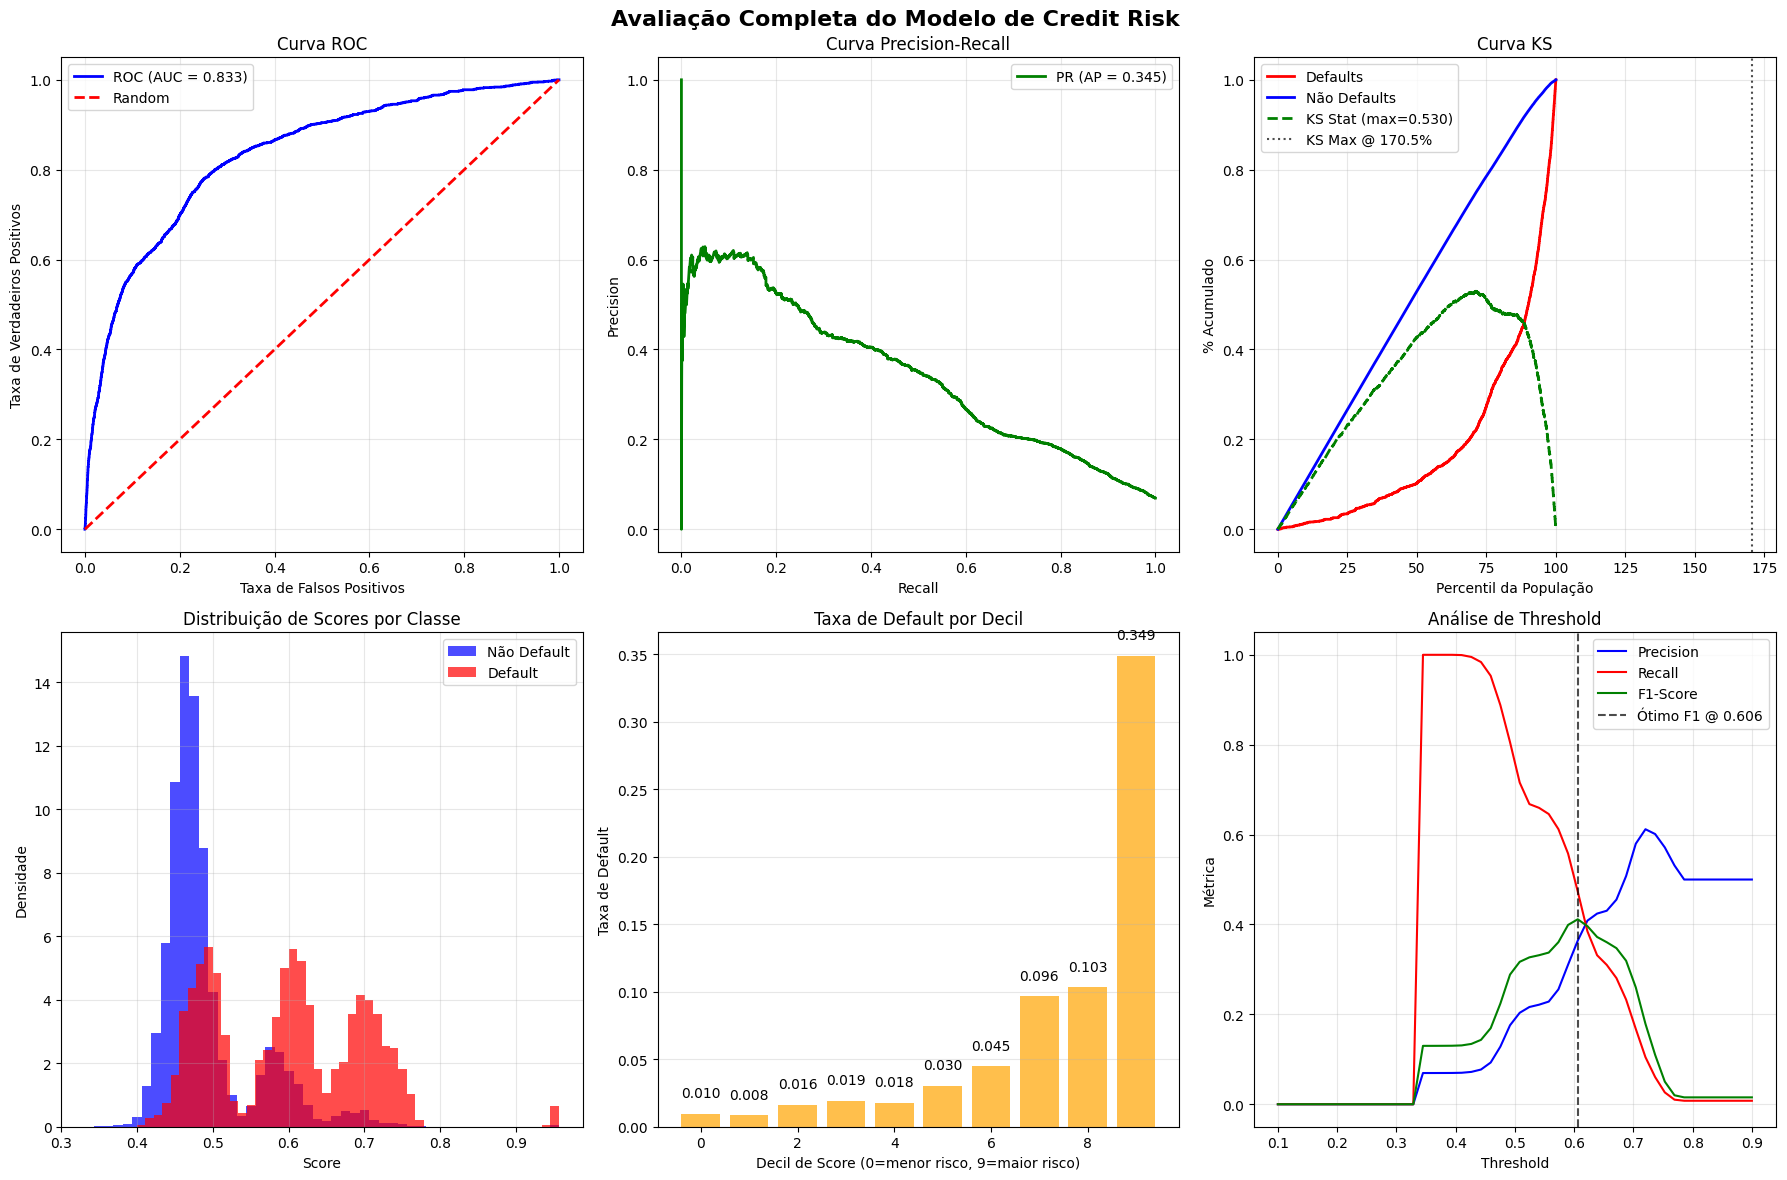


5️⃣ ANÁLISE DE THRESHOLD ÓTIMO:
-----------------------------------
YOUDEN:
   Threshold: 0.4966
   TPR: 0.7816 | FPR: 0.2521
   Critério: Máximo TPR - FPR

DISTANCE:
   Threshold: 0.4970
   TPR: 0.7792 | FPR: 0.2497
   Critério: Mínima distância ao ponto (0,1)

BUSINESS:
   Threshold: 0.4536
   TPR: 0.9743 | FPR: 0.7682
   Critério: Baseado em custo de negócio


🎉 AVALIAÇÃO COMPLETA CONCLUÍDA!
AUC Final no Teste: 0.8328
GINI Final: 0.6656
KS Statistic: 0.5295


In [111]:
# import necessary libraries f1 score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def avaliar_modelo_credit_risk_completo(model, scaler, X_train, X_val, X_test, 
                                       y_train, y_val, y_test, target_col='SeriousDlqin2yrs'):
    """
    Avaliação COMPLETA do modelo de credit risk
    """
    
    print("🎯 AVALIAÇÃO COMPLETA DO MODELO DE CREDIT RISK")
    print("=" * 60)
    
    # 1. GERAR PREDIÇÕES PARA TODOS OS CONJUNTOS
    print("1️⃣ GERANDO PREDIÇÕES...")
    
    # Padronizar dados
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val) 
    X_test_scaled = scaler.transform(X_test)
    
    # Probabilidades
    y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Predições binárias (threshold 0.5)
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    print(f"   ✅ Predições geradas para todos os conjuntos")
    
    # 2. MÉTRICAS FUNDAMENTAIS
    print(f"\n2️⃣ MÉTRICAS FUNDAMENTAIS:")
    print("-" * 40)
    
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
    
    conjuntos = {
        'Treino': (y_train, y_train_proba, y_train_pred),
        'Validação': (y_val, y_val_proba, y_val_pred),
        'Teste': (y_test, y_test_proba, y_test_pred)
    }
    
    resultados = {}
    
    for nome, (y_true, y_proba, y_pred) in conjuntos.items():
        auc = roc_auc_score(y_true, y_proba)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        resultados[nome] = {
            'AUC': auc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }
        
        print(f"{nome:>10}: AUC={auc:.4f} | Precision={precision:.4f} | Recall={recall:.4f} | F1={f1:.4f}")
    
    # Verificar overfitting
    overfitting_auc = resultados['Treino']['AUC'] - resultados['Teste']['AUC']
    if overfitting_auc > 0.05:
        print(f"⚠️  OVERFITTING detectado: diferença AUC = {overfitting_auc:.4f}")
    else:
        print(f"✅ Modelo generaliza bem: diferença AUC = {overfitting_auc:.4f}")
    
    return resultados, y_test_proba, y_test_pred

def calcular_metricas_credit_risk_detalhado(y_true, y_proba, y_pred=None):
    """
    Calcula TODAS as métricas específicas de credit risk
    """
    
    print("\n3️⃣ MÉTRICAS ESPECÍFICAS DE CREDIT RISK:")
    print("=" * 45)
    
    from scipy import stats
    
    # 1. AUC e GINI
    auc = roc_auc_score(y_true, y_proba)
    gini = 2 * auc - 1
    
    print(f"📊 DISCRIMINAÇÃO:")
    print(f"   AUC: {auc:.4f}")
    print(f"   GINI: {gini:.4f} (2×AUC - 1)")
    
    if auc >= 0.8:
        auc_status = "🏆 EXCELENTE"
    elif auc >= 0.7:
        auc_status = "✅ BOM"
    elif auc >= 0.6:
        auc_status = "⚠️ ACEITÁVEL"
    else:
        auc_status = "❌ RUIM"
    
    print(f"   Status: {auc_status}")
    
    # 2. KS STATISTIC
    print(f"\n📈 KS STATISTIC:")
    
    # Separar scores por classe
    scores_default = y_proba[y_true == 1]
    scores_no_default = y_proba[y_true == 0]
    
    # Teste KS
    ks_stat, ks_pvalue = stats.ks_2samp(scores_default, scores_no_default)
    
    print(f"   KS Statistic: {ks_stat:.4f}")
    print(f"   P-value: {ks_pvalue:.6f}")
    
    if ks_stat >= 0.4:
        ks_status = "🏆 EXCELENTE separação"
    elif ks_stat >= 0.3:
        ks_status = "✅ BOA separação"
    elif ks_stat >= 0.2:
        ks_status = "⚠️ SEPARAÇÃO moderada"
    else:
        ks_status = "❌ SEPARAÇÃO fraca"
    
    print(f"   Status: {ks_status}")
    
    # 3. ANÁLISE POR SCORE BANDS (DECIS)
    print(f"\n📊 ANÁLISE POR SCORE BANDS (DECIS):")
    
    df_analysis = pd.DataFrame({
        'score': y_proba,
        'default': y_true
    })
    
    # Criar decis
    df_analysis['decil'] = pd.qcut(df_analysis['score'], q=10, 
                                  labels=[f'D{i+1}' for i in range(10)])
    
    # Análise por decil
    bands_stats = df_analysis.groupby('decil').agg({
        'default': ['count', 'sum', 'mean'],
        'score': ['min', 'max', 'mean']
    }).round(4)
    
    # Flatten column names
    bands_stats.columns = ['Total', 'Defaults', 'Default_Rate', 'Score_Min', 'Score_Max', 'Score_Mean']
    
    # Adicionar percentual de defaults
    bands_stats['Default_Pct'] = (bands_stats['Defaults'] / bands_stats['Defaults'].sum() * 100).round(2)
    
    print(bands_stats)
    
    # Verificar monotonicidade
    is_monotonic = bands_stats['Default_Rate'].is_monotonic_increasing
    print(f"\n   Monotonicidade: {'✅ SIM' if is_monotonic else '❌ NÃO'}")
    
    if is_monotonic:
        print(f"   ✅ Modelo ordena corretamente o risco")
    else:
        print(f"   ⚠️ Modelo não ordena perfeitamente o risco")
    
    return {
        'AUC': auc,
        'GINI': gini,
        'KS_Statistic': ks_stat,
        'KS_pvalue': ks_pvalue,
        'Score_Bands': bands_stats,
        'Is_Monotonic': is_monotonic
    }

def plotar_curvas_avaliacao_completas(y_true, y_proba):
    """
    Plota TODAS as curvas importantes para credit risk
    """
    
    print("\n4️⃣ CURVAS DE AVALIAÇÃO:")
    print("=" * 30)
    
    from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Avaliação Completa do Modelo de Credit Risk', fontsize=16, fontweight='bold')
    
    # 1. ROC CURVE
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    
    axes[0, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {auc:.3f})')
    axes[0, 0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
    axes[0, 0].set_xlabel('Taxa de Falsos Positivos')
    axes[0, 0].set_ylabel('Taxa de Verdadeiros Positivos')
    axes[0, 0].set_title('Curva ROC')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. PRECISION-RECALL CURVE
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    
    axes[0, 1].plot(recall, precision, color='green', lw=2, 
                   label=f'PR (AP = {avg_precision:.3f})')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Curva Precision-Recall')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. KS CURVE
    plotar_ks_curve_detalhada(y_true, y_proba, axes[0, 2])
    
    # 4. DISTRIBUIÇÃO DE SCORES
    scores_default = y_proba[y_true == 1]
    scores_no_default = y_proba[y_true == 0]
    
    axes[1, 0].hist(scores_no_default, bins=50, alpha=0.7, label='Não Default', 
                   density=True, color='blue')
    axes[1, 0].hist(scores_default, bins=50, alpha=0.7, label='Default', 
                   density=True, color='red')
    axes[1, 0].set_xlabel('Score')
    axes[1, 0].set_ylabel('Densidade')
    axes[1, 0].set_title('Distribuição de Scores por Classe')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. SCORE BANDS (Taxa de Default por Decil)
    df_temp = pd.DataFrame({'score': y_proba, 'default': y_true})
    decis = pd.qcut(df_temp['score'], q=10, labels=False)
    default_por_decil = df_temp.groupby(decis)['default'].mean()
    
    axes[1, 1].bar(range(len(default_por_decil)), default_por_decil.values, 
                  color='orange', alpha=0.7)
    axes[1, 1].set_xlabel('Decil de Score (0=menor risco, 9=maior risco)')
    axes[1, 1].set_ylabel('Taxa de Default')
    axes[1, 1].set_title('Taxa de Default por Decil')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, rate in enumerate(default_por_decil.values):
        axes[1, 1].text(i, rate + 0.01, f'{rate:.3f}', ha='center', va='bottom')
    
    # 6. THRESHOLD ANALYSIS
    plotar_threshold_analysis(y_true, y_proba, axes[1, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Encontrar threshold ótimo
    threshold_otimo = encontrar_threshold_otimo_detalhado(y_true, y_proba, fpr, tpr, thresholds_roc)
    
    return {
        'fpr': fpr,
        'tpr': tpr,
        'thresholds_roc': thresholds_roc,
        'threshold_otimo': threshold_otimo,
        'auc': auc
    }

def plotar_ks_curve_detalhada(y_true, y_proba, ax):
    """
    Plota curva KS detalhada
    """
    
    # Criar DataFrame ordenado por score
    df_ks = pd.DataFrame({
        'score': y_proba,
        'default': y_true
    }).sort_values('score')
    
    # Calcular distribuições cumulativas
    n_defaults = df_ks['default'].sum()
    n_no_defaults = len(df_ks) - n_defaults
    
    df_ks['cum_defaults'] = df_ks['default'].cumsum() / n_defaults
    df_ks['cum_no_defaults'] = (1 - df_ks['default']).cumsum() / n_no_defaults
    df_ks['ks_stat'] = abs(df_ks['cum_defaults'] - df_ks['cum_no_defaults'])
    
    # Encontrar ponto de KS máximo
    max_ks_idx = df_ks['ks_stat'].idxmax()
    max_ks_value = df_ks.loc[max_ks_idx, 'ks_stat']
    max_ks_score = df_ks.loc[max_ks_idx, 'score']
    
    # Plotar
    percentiles = np.linspace(0, 100, len(df_ks))
    
    ax.plot(percentiles, df_ks['cum_defaults'], label='Defaults', color='red', lw=2)
    ax.plot(percentiles, df_ks['cum_no_defaults'], label='Não Defaults', color='blue', lw=2)
    ax.plot(percentiles, df_ks['ks_stat'], label=f'KS Stat (max={max_ks_value:.3f})', 
            color='green', lw=2, linestyle='--')
    
    # Marcar ponto de KS máximo
    max_ks_percentile = (max_ks_idx / len(df_ks)) * 100
    ax.axvline(x=max_ks_percentile, color='black', linestyle=':', alpha=0.7,
               label=f'KS Max @ {max_ks_percentile:.1f}%')
    
    ax.set_xlabel('Percentil da População')
    ax.set_ylabel('% Acumulado')
    ax.set_title('Curva KS')
    ax.legend()
    ax.grid(True, alpha=0.3)

def plotar_threshold_analysis(y_true, y_proba, ax):
    """
    Análise de diferentes thresholds
    """
    
    thresholds = np.linspace(0.1, 0.9, 50)
    precisions = []
    recalls = []
    f1_scores = []
    
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        
        if len(np.unique(y_pred_t)) > 1:  # Evitar divisão por zero
            prec = precision_score(y_true, y_pred_t)
            rec = recall_score(y_true, y_pred_t)
            f1 = f1_score(y_true, y_pred_t)
        else:
            prec = rec = f1 = 0
        
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
    
    ax.plot(thresholds, precisions, label='Precision', color='blue')
    ax.plot(thresholds, recalls, label='Recall', color='red')
    ax.plot(thresholds, f1_scores, label='F1-Score', color='green')
    
    # Marcar threshold ótimo (máximo F1)
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    
    ax.axvline(x=best_threshold, color='black', linestyle='--', alpha=0.7,
               label=f'Ótimo F1 @ {best_threshold:.3f}')
    
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Métrica')
    ax.set_title('Análise de Threshold')
    ax.legend()
    ax.grid(True, alpha=0.3)

def encontrar_threshold_otimo_detalhado(y_true, y_proba, fpr, tpr, thresholds):
    """
    Encontra thresholds ótimos usando diferentes critérios
    """
    
    print(f"\n5️⃣ ANÁLISE DE THRESHOLD ÓTIMO:")
    print("-" * 35)
    
    # 1. Youden's J Statistic
    j_scores = tpr - fpr
    optimal_idx_youden = np.argmax(j_scores)
    optimal_threshold_youden = thresholds[optimal_idx_youden]
    
    # 2. Closest to top-left corner
    distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
    optimal_idx_distance = np.argmin(distances)
    optimal_threshold_distance = thresholds[optimal_idx_distance]
    
    # 3. Business-based (assuming FN cost = 5x FP cost)
    cost_fn_fp_ratio = 5
    costs = fpr + cost_fn_fp_ratio * (1 - tpr)
    optimal_idx_cost = np.argmin(costs)
    optimal_threshold_cost = thresholds[optimal_idx_cost]
    
    thresholds_otimos = {
        'youden': {
            'threshold': optimal_threshold_youden,
            'tpr': tpr[optimal_idx_youden],
            'fpr': fpr[optimal_idx_youden],
            'description': 'Máximo TPR - FPR'
        },
        'distance': {
            'threshold': optimal_threshold_distance,
            'tpr': tpr[optimal_idx_distance],
            'fpr': fpr[optimal_idx_distance],
            'description': 'Mínima distância ao ponto (0,1)'
        },
        'business': {
            'threshold': optimal_threshold_cost,
            'tpr': tpr[optimal_idx_cost],
            'fpr': fpr[optimal_idx_cost],
            'description': 'Baseado em custo de negócio'
        }
    }
    
    for nome, info in thresholds_otimos.items():
        print(f"{nome.upper()}:")
        print(f"   Threshold: {info['threshold']:.4f}")
        print(f"   TPR: {info['tpr']:.4f} | FPR: {info['fpr']:.4f}")
        print(f"   Critério: {info['description']}")
        print()
    
    return thresholds_otimos

# EXECUTAR AVALIAÇÃO COMPLETA
print("🚀 Iniciando avaliação completa do modelo...")

# Verificar se o scaler está definido
if scaler is None:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train)  # Ajustar o scaler com os dados de treino

# Preprocessar os dados para lidar com valores NaN
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # Usar média para preencher valores NaN
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# 1. Métricas básicas
resultados_basicos, y_test_proba, y_test_pred = avaliar_modelo_credit_risk_completo(
    model, scaler, X_train, X_val, X_test, 
    y_train, y_val, y_test
)

# 2. Métricas detalhadas (usando conjunto de teste)
metricas_detalhadas = calcular_metricas_credit_risk_detalhado(
    y_test, y_test_proba, y_test_pred
)

# 3. Curvas e visualizações
info_curvas = plotar_curvas_avaliacao_completas(y_test, y_test_proba)

print(f"\n🎉 AVALIAÇÃO COMPLETA CONCLUÍDA!")
print(f"AUC Final no Teste: {metricas_detalhadas['AUC']:.4f}")
print(f"GINI Final: {metricas_detalhadas['GINI']:.4f}")
print(f"KS Statistic: {metricas_detalhadas['KS_Statistic']:.4f}")